In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.metrics import *
#from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.neural_network import MLPClassifier

### Data Cleaning Begins

Lets first load the train data

In [697]:
training_file = 'C2T1_Train.csv'
testing_file = 'C2T1_Test.csv'

In [698]:
data = pd.read_csv(training_file)
data.head(n=5)

,encounter_id2,patient_nbr2,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,5283,48330653,Caucasian,Female,[80-90),?,2,1,4,13,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
1,8499,63555809,Caucasian,Female,[90-100),?,3,3,4,12,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
2,9441,42519137,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
3,20997,89868902,AfricanAmerican,Female,[40-50),?,1,1,7,9,...,No,Steady,No,No,No,No,No,No,Yes,>30
4,28515,82637321,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30


Seems we have to change ? to nan data first.

In [699]:
data.replace('?',pd.NA, inplace=True)

<Axes: >

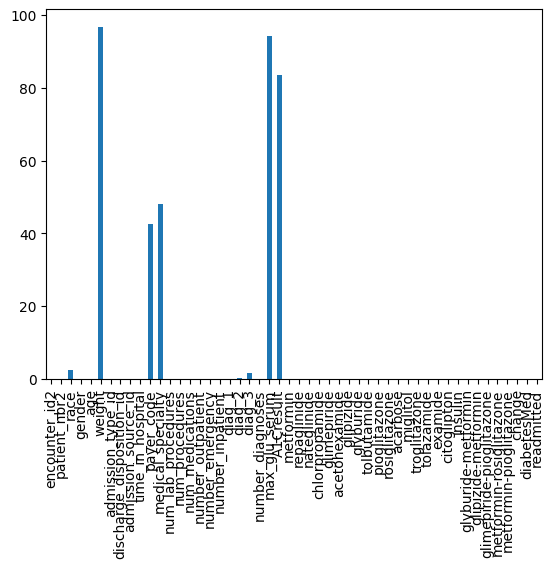

In [700]:
((data.isna().sum() / len(data)) * 100).plot(kind='bar')

Lets only the weight, it missing lots of data, and they seems not that important than Max_glu_serum and A1Cresult to predict the readmitted.

In [701]:
data.drop(['weight'], axis=1, inplace=True)

check number of unique values for each feature.

In [702]:
data.nunique()

encounter_id2               90766
patient_nbr2                65765
race                            5
gender                          3
age                            10
admission_type_id               8
discharge_disposition_id       26
admission_source_id            17
time_in_hospital               14
payer_code                     17
medical_specialty              71
num_lab_procedures            118
num_procedures                  7
num_medications                74
number_outpatient              36
number_emergency               33
number_inpatient               21
diag_1                        700
diag_2                        733
diag_3                        769
number_diagnoses               16
max_glu_serum                   3
A1Cresult                       3
metformin                       4
repaglinide                     4
nateglinide                     4
chlorpropamide                  4
glimepiride                     4
acetohexamide                   2
glipizide     

drop the features that only have one unique value

In [703]:
# Calculate the number of unique values for each column
unique_values = data.nunique()

# Get the list of columns with only one unique value
columns_to_drop = unique_values[unique_values == 1].index

# Drop the columns from the DataFrame
data = data.drop(columns=columns_to_drop)

lets check all rows data are unique or not? if unique 

In [704]:
data.duplicated().sum()

0

check the remain features

let analyze them one by one.

Race

<Axes: ylabel='count'>

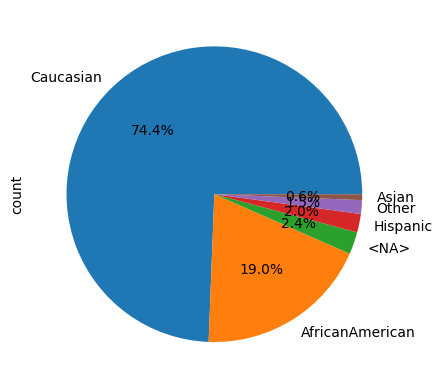

In [705]:
data['race'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%')

2.4% NA, lets filling NA values of race with mode (will add to caucasians).

<Axes: ylabel='count'>

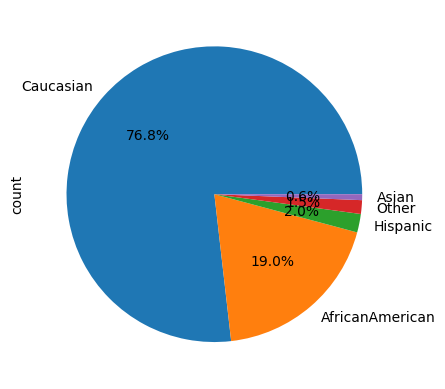

In [706]:
# Fill NaN values in the 'race' column with the mode
mode_race = data['race'].mode()[0]
data['race'] = data['race'].fillna(mode_race)

data['race'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%')

Gender

<Axes: ylabel='count'>

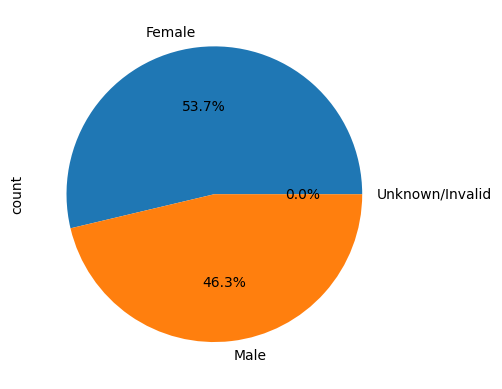

In [707]:
data['gender'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%')

The Unknown amount is not big, lets check them to see we keep them or drop it.

In [708]:
data[data['gender'] == 'Unknown/Invalid']

,encounter_id2,patient_nbr2,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
30506,98627619,100694912,Other,Unknown/Invalid,[70-80),3,1,1,1,<NA>,...,No,No,No,No,No,No,No,Ch,Yes,NO
64551,226857429,60524816,Caucasian,Unknown/Invalid,[60-70),1,1,7,1,CP,...,No,No,No,No,No,No,No,No,No,NO
71573,257357055,78119717,Caucasian,Unknown/Invalid,[70-80),1,22,7,8,CP,...,No,No,No,No,No,No,No,Ch,Yes,NO


seems useful let just change Unknown/Invalid gender to mode gender. (Female)

<Axes: ylabel='count'>

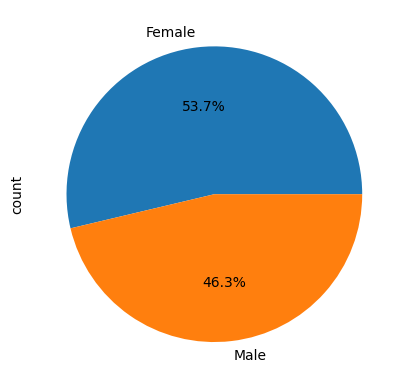

In [709]:
# Find the mode gender
mode_gender = data['gender'].mode()[0]

# Replace 'Unknown/Invalid' with mode gender
data['gender'] = data['gender'].replace('Unknown/Invalid', mode_gender).infer_objects(copy=False)

data['gender'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%')

Age

<Axes: ylabel='count'>

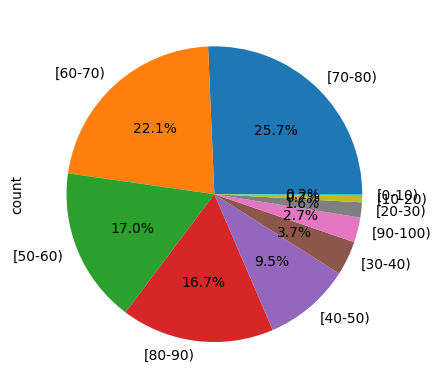

In [710]:
data['age'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%')

I think we can group the data as 0-50, 50-60, 60-70, 70-80 and 80-100 5 groups total.

<Axes: ylabel='count'>

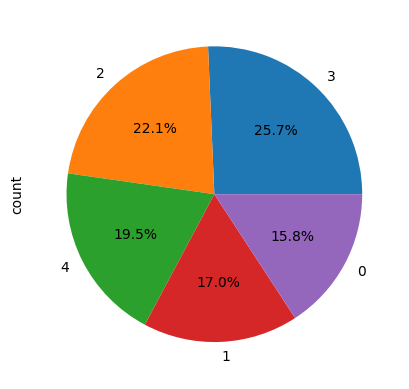

In [711]:
def map_new_age_group(age_group):
    if age_group == '[0-10)' or age_group == '[10-20)' or age_group == '[20-30)' or age_group == '[30-40)' or age_group == '[40-50)':
        return 0
    elif age_group == '[50-60)':
        return 1
    elif age_group == '[60-70)':
        return 2
    elif age_group == '[70-80)':
        return 3
    elif age_group == '[80-90)' or age_group == '[90-100)':
        return 4

# Apply the function to create a new column for new age groups
data['age'] = data['age'].apply(map_new_age_group)

# Display the value counts for the new age groups
data['age'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%')

Admission type id

Lets read the mapping file to help draw the figure

In [712]:
from io import StringIO
mapping_path = "C2T1_IDs_mapping.csv"

# Read the CSV file
with open(mapping_path, "r") as file:
    mapping_data = file.read()

# Split the data into separate sections based on ",\n"
sections = mapping_data.split(",\n")

# Extract the sections for each DataFrame
admission_type_section = sections[0]
discharge_disposition_section = sections[1]
admission_source_section = sections[2]

# Convert each section to a DataFrame
admission_type_mapping = pd.read_csv(StringIO(admission_type_section))
discharge_disposition_mapping = pd.read_csv(StringIO(discharge_disposition_section))
admission_source_mapping = pd.read_csv(StringIO(admission_source_section))


In [713]:
admission_type_mapping

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped


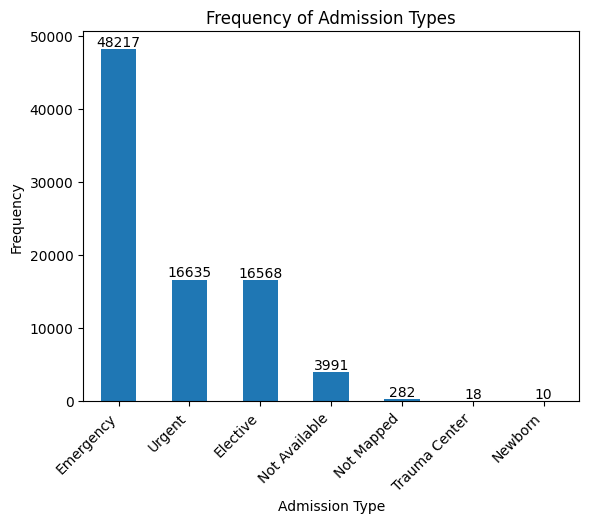

In [714]:
# Map admission_type_id to admission_type_description using the admission_type_mapping DataFrame
admission_type_description = data['admission_type_id'].map(admission_type_mapping.set_index('admission_type_id')['description'])

# Count the frequency of each admission type
admission_type_counts = admission_type_description.value_counts()

# plot the bar chart
admission_type_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Admission Type')
plt.ylabel('Frequency')
plt.title('Frequency of Admission Types')
plt.xticks(rotation=45, ha='right') 

# Display the count on top of each bar
for i, count in enumerate(admission_type_counts):
    plt.text(i, count , str(count), ha='center', va='bottom')

plt.show()

most of the patients are admitted with emergency, followed by urgent and elective.

discharge disposition id

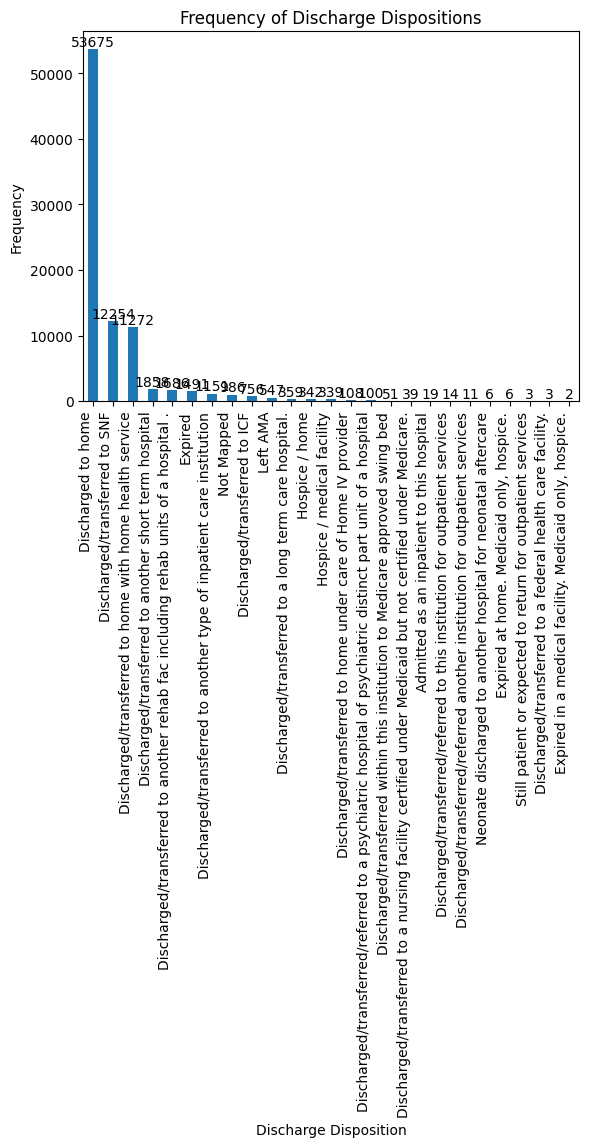

In [715]:
# Map discharge_disposition_id to description using the discharge_disposition_mapping DataFrame
discharge_disposition_description = data['discharge_disposition_id'].map(discharge_disposition_mapping.set_index('discharge_disposition_id')['description'])

# Count the frequency of each discharge disposition
discharge_disposition_counts = discharge_disposition_description.value_counts()

# Plot the bar chart
discharge_disposition_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Discharge Disposition')
plt.ylabel('Frequency')
plt.title('Frequency of Discharge Dispositions')
plt.xticks(rotation=90, ha='right') 

# Display the count on top of each bar
for i, count in enumerate(discharge_disposition_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

To many labels, Lets group them by health care strong or not.

In [716]:
def group_discharge_disposition(code):
    rich_health_care = [2, 3, 4, 5, 9, 10, 15, 16, 17, 23, 27, 28, 29]
    limited_health_care_not_home = [6, 7, 8, 12, 22, 24, 30]
    home = [1]
    expired_hospice = [11, 13, 14, 19, 20, 21]
    no_info = [18, 25, 26]
    
    if code in rich_health_care:
        return 1
    elif code in limited_health_care_not_home:
        return 2
    elif code in home:
        return 3
    elif code in expired_hospice:
        return 4
    elif code in no_info:
        return 5
# Apply the function to create a new column with the group labels
data['discharge_disposition_group'] = data['discharge_disposition_id'].apply(group_discharge_disposition)
# Drop the old id column
data.drop(columns=['discharge_disposition_id'], inplace=True)

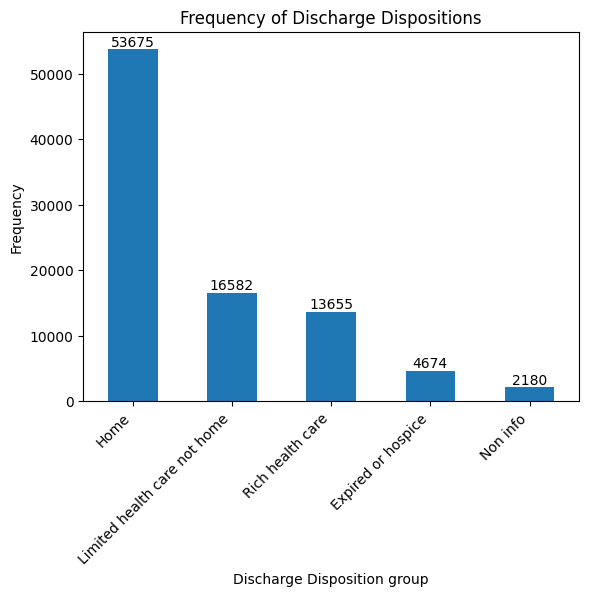

In [717]:
# Count the frequency of each discharge disposition
discharge_disposition_counts = data['discharge_disposition_group'].value_counts()
# Add label to it
discharge_disposition_counts.index = ['Home', 'Limited health care not home', 'Rich health care', 'Expired or hospice', 'Non info']
# Plot the bar chart
discharge_disposition_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Discharge Disposition group')
plt.ylabel('Frequency')
plt.title('Frequency of Discharge Dispositions')
plt.xticks(rotation=45, ha='right') 

# Display the count on top of each bar
for i, count in enumerate(discharge_disposition_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

Admission source id

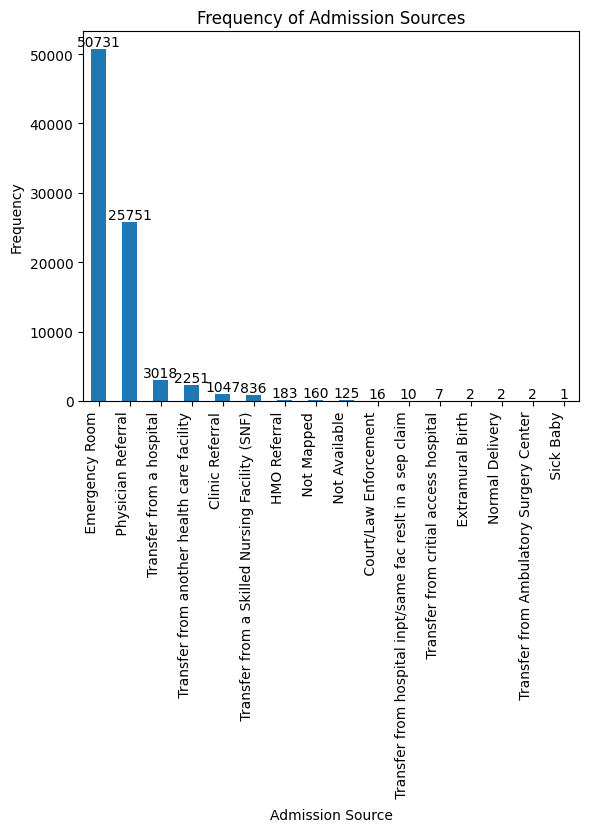

In [718]:
# Map admission_source_id to description using the admission_source_mapping DataFrame
admission_source_description = data['admission_source_id'].map(admission_source_mapping.set_index('admission_source_id')['description'])

# Count the frequency of each admission source
admission_source_counts = admission_source_description.value_counts()

# Plot the bar chart
admission_source_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Admission Source')
plt.ylabel('Frequency')
plt.title('Frequency of Admission Sources')
plt.xticks(rotation=90, ha='right') 

# Display the count on top of each bar
for i, count in enumerate(admission_source_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

Strange data, lets group them by age. there is baby in this data.

In [719]:
# Define the categories for grouping
baby_sources = [11, 12, 13, 14, 23, 24]
elder_sources = [5, 18, 19, 26]
adult_sources = [2, 3, 4, 6, 8, 10, 22, 25]
emergency = [7]
physician = [1]
no_info = [9, 15, 17, 20, 21]

# Function to categorize admission sources
def group_admission_source(admission_source_id):
    if admission_source_id in baby_sources:
        return 1
    elif admission_source_id in elder_sources:
        return 2
    elif admission_source_id in adult_sources:
        return 3
    elif admission_source_id in emergency:
        return 4
    elif admission_source_id in physician:
        return 5
    elif admission_source_id in no_info:
        return 6

# Apply the function to create a new column with the categories
data['admission_source_group'] = data['admission_source_id'].apply(group_admission_source)

# Drop the old id column
data.drop(columns=['admission_source_id'], inplace=True)

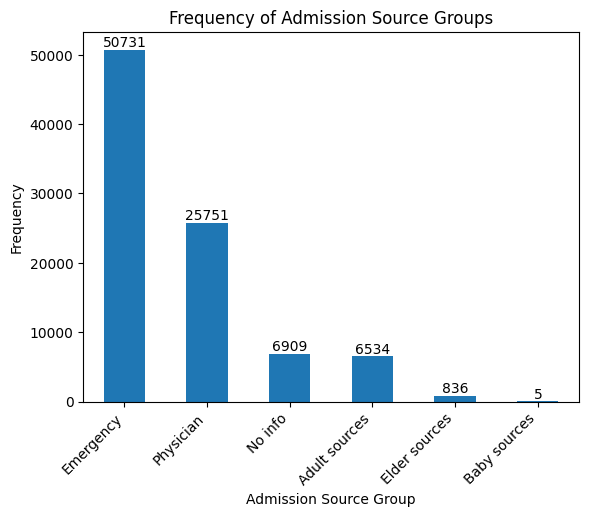

In [720]:
# Count the frequency of each admission source group
admission_source_counts = data['admission_source_group'].value_counts()

# Add label to it
admission_source_counts.index = ['Emergency', 'Physician', 'No info', 'Adult sources', 'Elder sources', 'Baby sources']

# Plot the bar chart
admission_source_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Admission Source Group')
plt.ylabel('Frequency')
plt.title('Frequency of Admission Source Groups')
plt.xticks(rotation=45, ha='right') 

# Display the count on top of each bar
for i, count in enumerate(admission_source_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()


Time in hospital

<Axes: ylabel='count'>

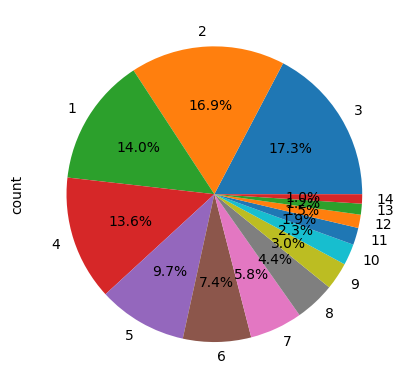

In [721]:
data['time_in_hospital'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%')

Most of patients only stay in hospital within a week.

payer code and medical specialty can be observed after imputation.

num lab procedures - number of lab tests performed during the encounter

<Axes: xlabel='num_lab_procedures'>

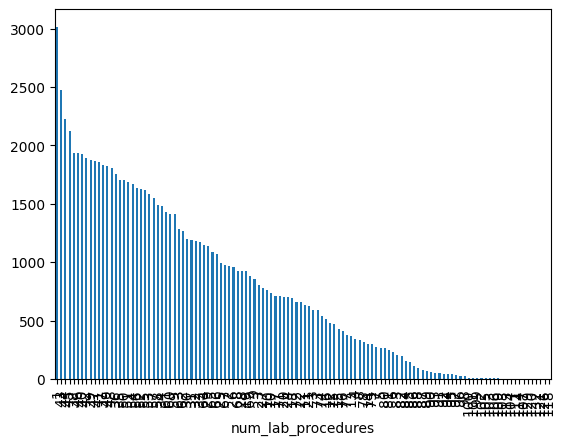

In [722]:
data['num_lab_procedures'].value_counts(dropna=False).plot(kind='bar')

In [723]:
data['num_lab_procedures'].mean()

42.84862173060397

lots of data leave it. 43 avg.

Num_procedures

<Axes: xlabel='num_procedures'>

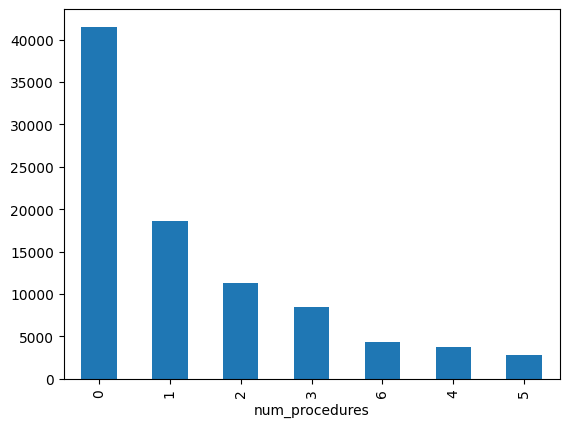

In [724]:
data['num_procedures'].value_counts(dropna=False).plot(kind='bar')

In [725]:
data['num_procedures'].mean()

1.341868100390014

numeric feature, most of them have 0 procedure. avg 1.34.

Num medications

<Axes: xlabel='num_medications'>

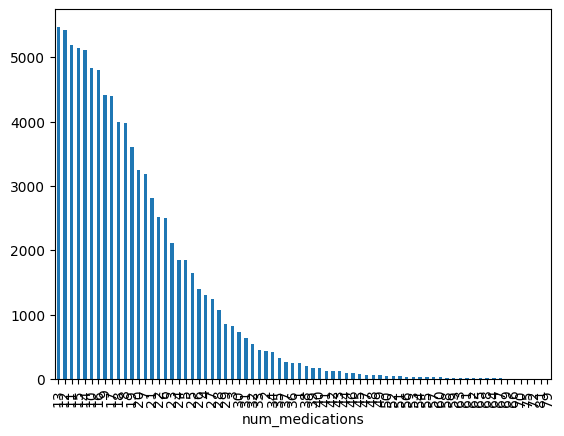

In [726]:
data['num_medications'].value_counts(dropna=False).plot(kind='bar')

In [727]:
data['num_medications'].mean()

15.912885882378864

lots of data, avg number of distinct generic names administered during the encounter is 16

Number_outpatient

<Axes: xlabel='number_outpatient'>

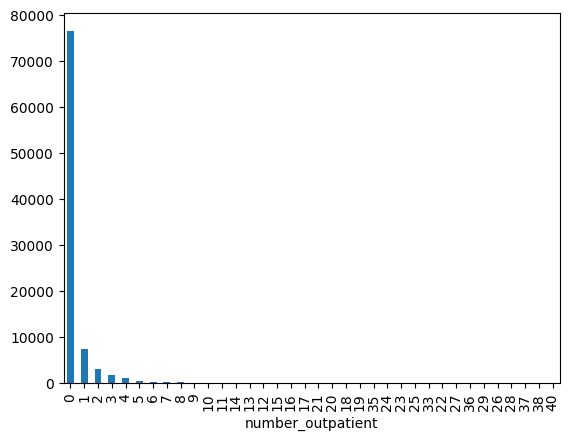

In [728]:
data['number_outpatient'].value_counts(dropna=False).plot(kind='bar')

outpatient visits of the patient in the year preceding the encounter. most of are 0.

Number_emergency - emergency visits of the patient in the year preceding the encounter

<Axes: xlabel='number_emergency'>

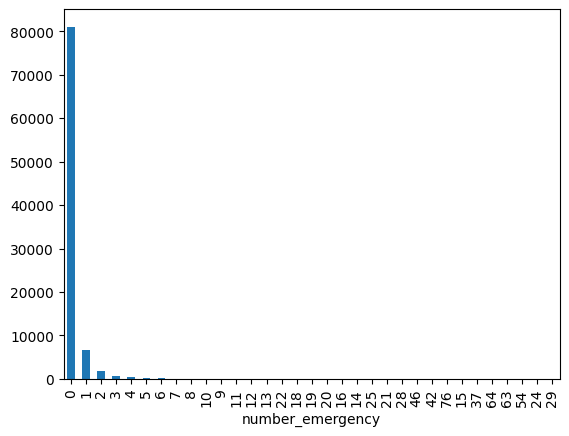

In [729]:
data['number_emergency'].value_counts(dropna=False).plot(kind='bar')

most of are 0 too.

Number_inpatient - inpatient visits of the patient in the year preceding the encounter

<Axes: xlabel='number_inpatient'>

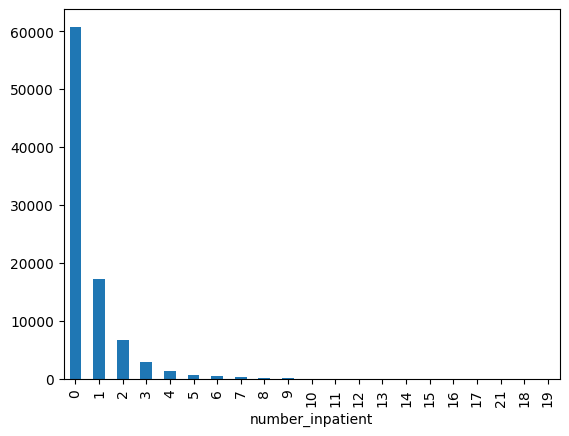

In [730]:
data['number_inpatient'].value_counts(dropna=False).plot(kind='bar')

In [731]:
data['number_inpatient'].mean()

0.624628164731287

Most of 0 and some 1, and avg is 0.62

Diagnosis

<Axes: xlabel='diag_1'>

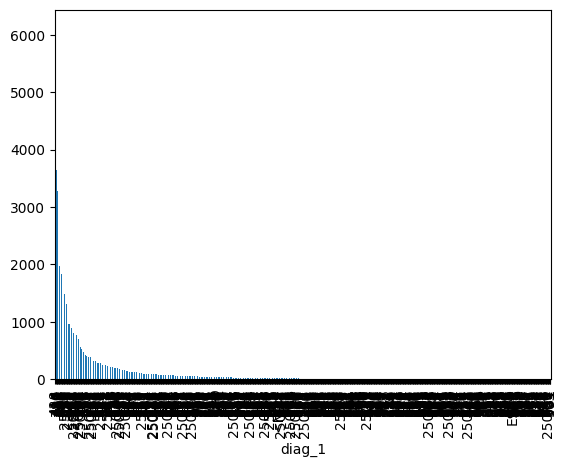

In [732]:
data['diag_1'].value_counts(dropna=False).plot(kind='bar')

To many datas!!
We can categorize these codes into the 9 categories given above and use them as diagnosis of diseases which come under these 9 categories. This idea has been taken from the research paper:
https://www.kaggle.com/iabhishekofficial/prediction-on-hospital-readmission.

In [733]:
# Function to map diagnosis codes to disease categories
def map_diagnosis_to_category(code):
    if pd.isna(code):
        return -1  # Replace NA with -1
    elif code.startswith('V') or code.startswith('E'):
        return 0  # Replace V and E with 0
    else:
        code = float(code)
        if (code >= 390 and code < 460) or (np.floor(code) == 785):
            return 1  # Circulatory
        elif (code >= 460 and code < 520) or (np.floor(code) == 786):
            return 2  # Respiratory
        elif (code >= 520 and code < 580) or (np.floor(code) == 787):
            return 3  # Digestive
        elif (np.floor(code) == 250):
            return 4  # Diabetes
        elif (code >= 800 and code < 1000):
            return 5  # Injury
        elif (code >= 710 and code < 740):
            return 6  # Musculoskeletal
        elif (code >= 580 and code < 630) or (np.floor(code) == 788):
            return 7  # Genitourinary
        elif (code >= 140 and code < 240):
            return 8  # Neoplasms
        else:
            return 0  # Others

# Columns for diagnosis
diagnosis_columns = ['diag_1', 'diag_2', 'diag_3']

# Create new columns for diagnosis categories
for col in diagnosis_columns:
    new_col_name = col + '_category'
    data[new_col_name] = data[col].apply(map_diagnosis_to_category)

Drop the old one

In [734]:
# Drop the original diagnosis columns
data.drop(diagnosis_columns, axis=1, inplace=True)

Lets plot the new one.

<Axes: xlabel='diag_1_category'>

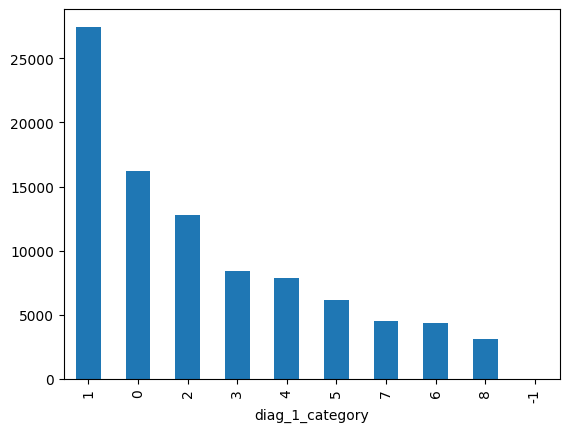

In [735]:
data['diag_1_category'].value_counts().plot(kind='bar')

<Axes: xlabel='diag_2_category'>

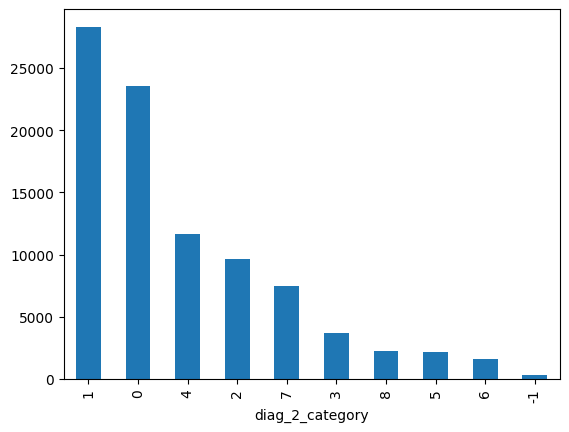

In [736]:
data['diag_2_category'].value_counts(dropna=False).plot(kind='bar')

<Axes: xlabel='diag_3_category'>

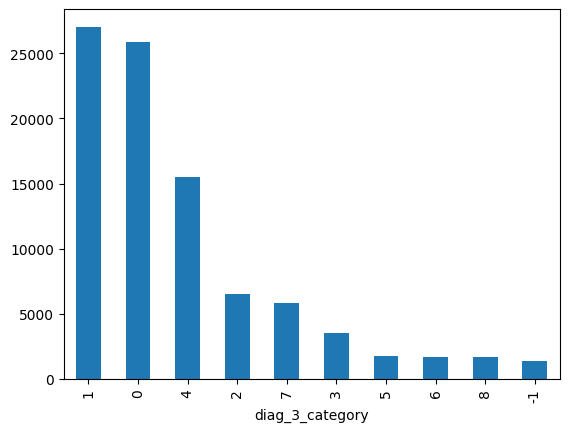

In [737]:
data['diag_3_category'].value_counts(dropna=False).plot(kind='bar')

diag 1 primary has very rare of NA disease, second and additional diag increase it a little bit. and most of them have other disease type

Number_diagnoses

<Axes: xlabel='number_diagnoses'>

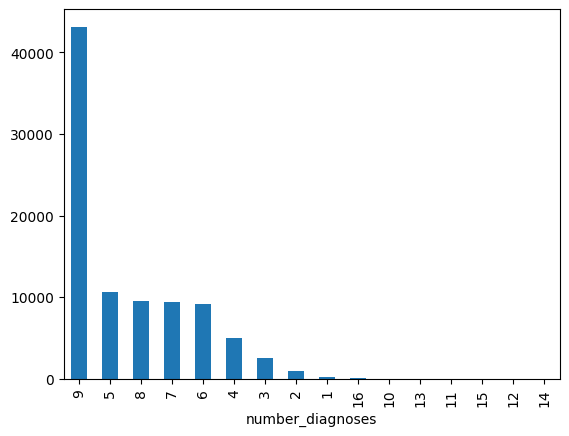

In [738]:
data['number_diagnoses'].value_counts(dropna=False).plot(kind='bar')

In [739]:
data['number_diagnoses'].mean()

7.37937113015887

Most patients have 9 diagnoses, avg is 7.4

its check the data again

In [740]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90766 entries, 0 to 90765
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   encounter_id2                90766 non-null  int64 
 1   patient_nbr2                 90766 non-null  int64 
 2   race                         90766 non-null  object
 3   gender                       90766 non-null  object
 4   age                          90766 non-null  int64 
 5   admission_type_id            90766 non-null  int64 
 6   time_in_hospital             90766 non-null  int64 
 7   payer_code                   52036 non-null  object
 8   medical_specialty            47092 non-null  object
 9   num_lab_procedures           90766 non-null  int64 
 10  num_procedures               90766 non-null  int64 
 11  num_medications              90766 non-null  int64 
 12  number_outpatient            90766 non-null  int64 
 13  number_emergency             90

The following data are mostly object, let check do we need to categorize them or not.

max_glu_serum Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured. Keep it because it is curial for diabetic

<Axes: ylabel='count'>

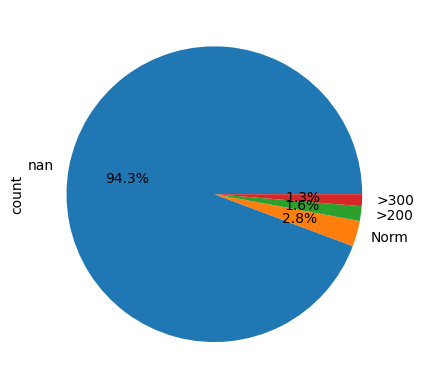

In [741]:
data['max_glu_serum'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%')

Looks we cannot categorize this farther, just change nan to not_taken.

In [743]:
# Replace NaN values with 'not_taken'
data['max_glu_serum'] = data['max_glu_serum'].fillna(0)
data['max_glu_serum'] = data['max_glu_serum'].replace({'Norm': 1, '>200': 2, '>300': 3}).infer_objects(copy=False)

A1Cresult Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured. keep it because it is critical for diabetic

<Axes: ylabel='count'>

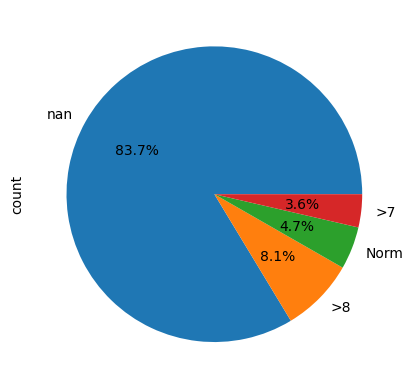

In [744]:
data['A1Cresult'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%')

Same as the max_glu_serum let just change nan to not taken

In [746]:
# Replace NaN values with 'not_taken'
data['A1Cresult'] = data['A1Cresult'].fillna(0)
data['A1Cresult'] = data['A1Cresult'].replace({'Norm': 1, '>7': 2, '>8': 3}).infer_objects(copy=False)

23 features for medications - For the generic names: metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, and metformin-pioglitazone, the feature indicates whether the drug was prescribed or there was a change in the dosage. Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed, 2 medication already dropped.

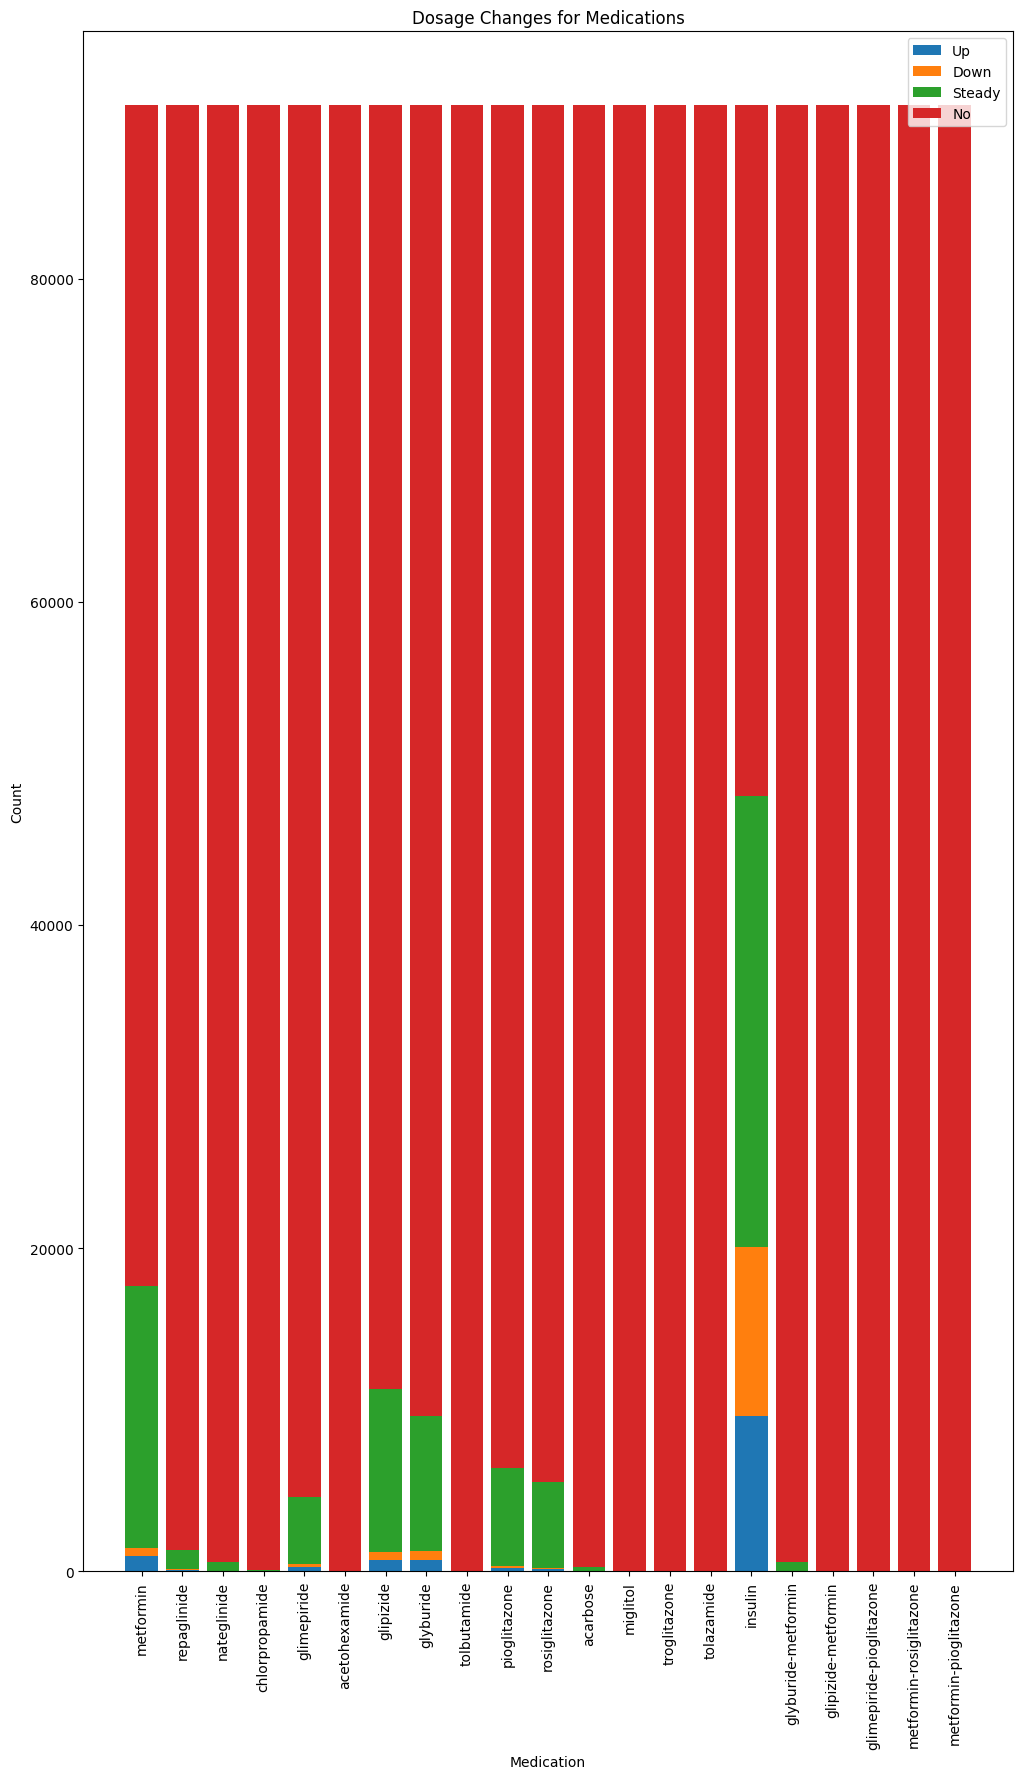

In [747]:
# List of medication features
medication_features = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
    'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
    'metformin-rosiglitazone', 'metformin-pioglitazone'
]

# Dictionary to store dosage change counts
dosage_changes = {'Up': np.zeros(len(medication_features)), 
                  'Down': np.zeros(len(medication_features)), 
                  'Steady': np.zeros(len(medication_features)), 
                  'No': np.zeros(len(medication_features))}

# Iterate over each medication feature
for feature_index, feature in enumerate(medication_features):
    # Iterate over dosage changes and count occurrences
    for change in dosage_changes.keys():
        # Count occurrences of dosage change for the current medication feature
        dosage_changes[change][feature_index] = data[data[feature] == change].shape[0]

# Plot the bar chart
plt.figure(figsize=(12, 20))  # Increase height to show the Up and Down
bottom = None
for change, counts in dosage_changes.items():
    plt.bar(medication_features, counts, label=change, bottom=bottom)
    if bottom is None:
        bottom = counts
    else:
        bottom += counts

plt.xlabel('Medication')
plt.ylabel('Count')
plt.title('Dosage Changes for Medications')
plt.legend()
plt.xticks(rotation=90)
plt.show()

Looks most of them are No. all four of them may cause different behaviour, so we decided to keep it like this

In [749]:
medication_features = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
    'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
    'metformin-rosiglitazone', 'metformin-pioglitazone'
]

# Dictionary to map dosage changes to numerical values
dosage_mapping = {'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3}

# Initialize a dictionary to store dosage change counts
dosage_changes = {change: np.zeros(len(medication_features)) for change in dosage_mapping.keys()}

# Iterate over each medication feature
for feature_index, feature in enumerate(medication_features):
    # Replace dosage changes with numerical values
    data[feature] = data[feature].replace(dosage_mapping).infer_objects(copy=False)
    
    # Count occurrences of dosage change for the current medication feature
    for change in dosage_mapping.keys():
        dosage_changes[change][feature_index] = (data[feature] == dosage_mapping[change]).sum()

Change the Med or not

<Axes: ylabel='count'>

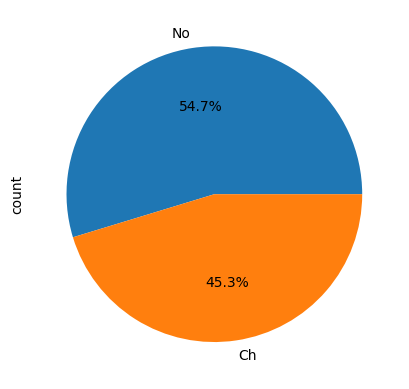

In [750]:
data['change'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%')

Looks very balanced and no need to group.

In [752]:
# Replace 'No' with 0 and 'Ch' with 1 in the 'change' column
data['change'] = data['change'].replace({'No': 0, 'Ch': 1}).infer_objects(copy=False)

DiabetesMed - Indicates if there was any diabetic medication prescribed. Values: “yes” and “no”

<Axes: ylabel='count'>

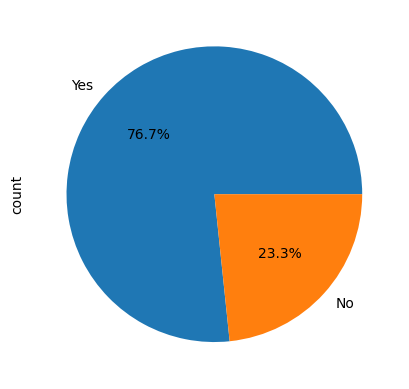

In [753]:
data['diabetesMed'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%')

Likes good, lets keep them like this

In [757]:
# Replace 'No' with 0 and 'Yes' with 1 in the 'diabetesMed' column
data['diabetesMed'] = data['diabetesMed'].replace({'No': 0, 'Yes': 1}).infer_objects(copy=False)

Readmitted - Days to inpatient readmission. Values: “<30” if the patient was readmitted in less than 30 days, “>30” if the patient was readmitted in more than 30 days, and “No” for no record of readmission. 

<Axes: ylabel='count'>

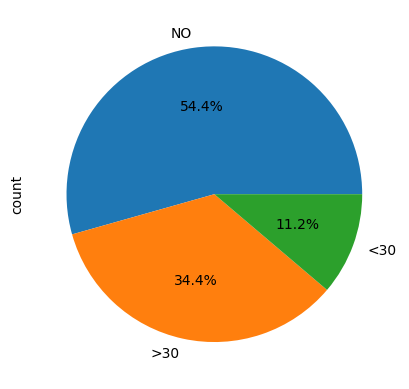

In [755]:
data['readmitted'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%')

The label we are facing is imbalanced, we can use SMOTE-NC for training data.

In [758]:
# Replace 'No' with 0 and '<30' with 1 and '>30' with 2 in the 'readmitted' column
data['readmitted'] = data['readmitted'].replace({'<30': 1, '>30': 2, 'NO': 0}).infer_objects(copy=False)

Now, time to get payer code and medical_specialty, these two are important because we can say that the payer is not cover patient may not readmitted in 30 days. medical specialty as the identifier of a specialty of the admitting physician if the doctor is not good patient may admitted again. Let draw them

<Axes: xlabel='payer_code'>

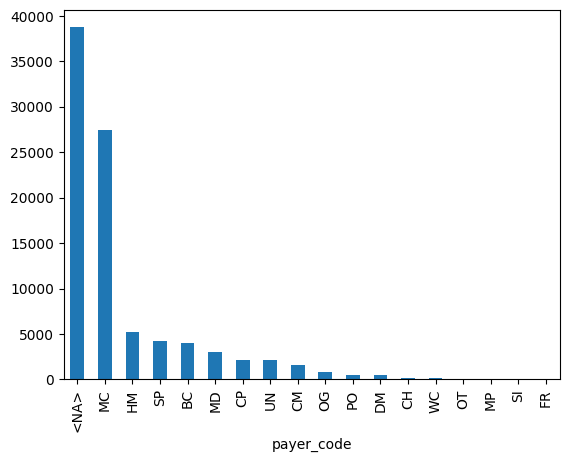

In [760]:
data['payer_code'].value_counts(dropna=False).plot(kind='bar')

<Axes: xlabel='medical_specialty'>

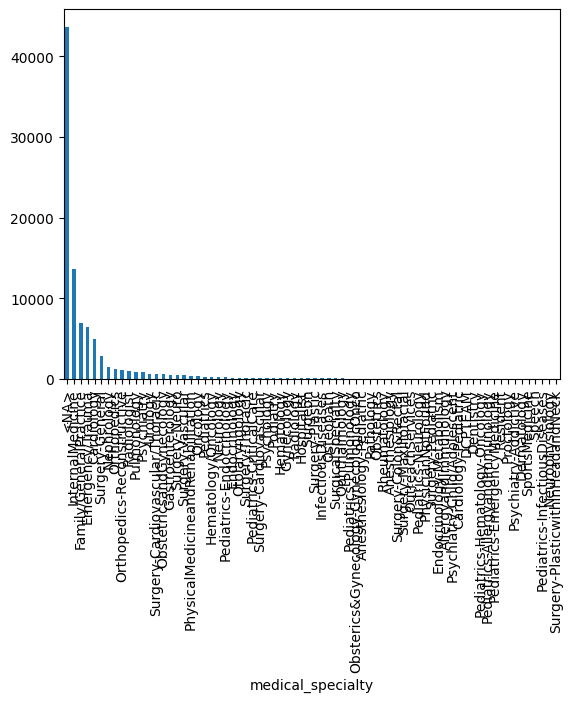

In [761]:
data['medical_specialty'].value_counts(dropna=False).plot(kind='bar')

Lets try clustering to group the data and find the values for these two

In [762]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

# Prepare features for clustering, excluding the target columns for imputation
features_for_clustering = data.drop(columns=['payer_code', 'medical_specialty'])

# Identify categorical columns for one-hot encoding
categorical_cols = features_for_clustering.select_dtypes(include=['object', 'category']).columns

# Initialize OneHotEncoder
encoder = OneHotEncoder(drop='first')

# Apply OneHotEncoder to categorical columns and convert to DataFrame
encoded_features = encoder.fit_transform(features_for_clustering[categorical_cols])
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out())

# Drop original categorical columns from the dataset
features_for_clustering = features_for_clustering.drop(columns=categorical_cols)

# Concatenate the original numeric features with the new encoded features
# Make sure to reset index to align the rows correctly
features_for_clustering = pd.concat([features_for_clustering.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Perform clustering with KMeans
kmeans = KMeans(n_clusters=50, random_state=0).fit(features_for_clustering)

# Assign cluster labels to each record in the original DataFrame
data['Cluster'] = kmeans.labels_

# Calculate the overall mode for each column as a fallback
overall_mode_payer_code = data['payer_code'].mode().values[0] if not data['payer_code'].mode().empty else None
overall_mode_medical_specialty = data['medical_specialty'].mode().values[0] if not data['medical_specialty'].mode().empty else None

for column, overall_mode in [('payer_code', overall_mode_payer_code), ('medical_specialty', overall_mode_medical_specialty)]:
    for cluster in data['Cluster'].unique():
        mode_value = data.loc[data['Cluster'] == cluster, column].mode().values
        if mode_value.size > 0:
            data.loc[(data['Cluster'] == cluster) & (data[column].isnull()), column] = mode_value[0]
        else:
            # If no mode is found within the cluster, use the overall mode
            if overall_mode is not None:
                data.loc[(data['Cluster'] == cluster) & (data[column].isnull()), column] = overall_mode

# remove the 'Cluster' column, it's no longer needed
data.drop(columns=['Cluster'], inplace=True)

Check the result

<Axes: xlabel='payer_code'>

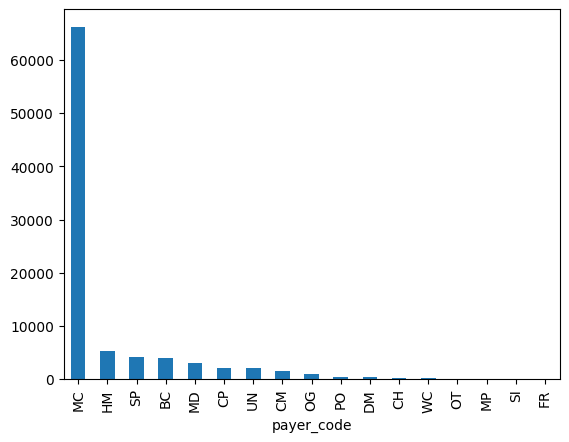

In [763]:
data['payer_code'].value_counts(dropna=False).plot(kind='bar')

<Axes: xlabel='medical_specialty'>

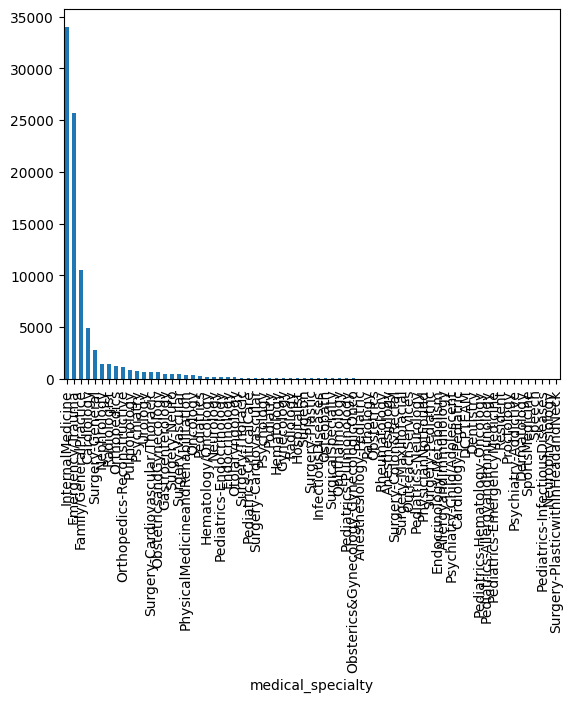

In [764]:
data['medical_specialty'].value_counts(dropna=False).plot(kind='bar')

looks good.

change the category value to category.

In [767]:
columns_to_convert = ['admission_type_id','discharge_disposition_group', 'admission_source_group', 'diag_1_category', 'diag_2_category', 'diag_3_category']
data[columns_to_convert] = data[columns_to_convert].astype('category')

Drop the useless data and separated feature and labels

In [768]:
# Drop 'encounter_id2', 'patient_nbr2', and separate features and labels
X = transformed_data.drop(['readmitted', 'encounter_id2', 'patient_nbr2'], axis=1)  # Features
y = data['readmitted']  # Labels

In [769]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90766 entries, 0 to 90765
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   race                         90766 non-null  object  
 1   gender                       90766 non-null  object  
 2   age                          90766 non-null  int32   
 3   admission_type_id            90766 non-null  category
 4   time_in_hospital             90766 non-null  int64   
 5   payer_code                   90766 non-null  object  
 6   medical_specialty            90766 non-null  object  
 7   num_lab_procedures           90766 non-null  int64   
 8   num_procedures               90766 non-null  int64   
 9   num_medications              90766 non-null  int64   
 10  number_outpatient            90766 non-null  int64   
 11  number_emergency             90766 non-null  int64   
 12  number_inpatient             90766 non-null  int64   
 13  n

Apply one hot

In [770]:
X_encoded = pd.get_dummies(X)
X_encoded

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,...,diag_3_category_-1,diag_3_category_0,diag_3_category_1,diag_3_category_2,diag_3_category_3,diag_3_category_4,diag_3_category_5,diag_3_category_6,diag_3_category_7,diag_3_category_8
0,4,13,68,2,28,0,0,0,8,3,...,False,True,False,False,False,False,False,False,False,False
1,4,12,33,3,18,0,0,0,8,3,...,False,False,False,True,False,False,False,False,False,False
2,0,1,51,0,8,0,0,0,5,3,...,False,False,False,False,False,True,False,False,False,False
3,0,9,47,2,17,0,0,0,9,3,...,False,False,False,False,False,False,True,False,False,False
4,1,3,31,6,16,0,0,0,9,3,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90761,3,3,51,0,16,0,0,0,9,3,...,False,False,True,False,False,False,False,False,False,False
90762,4,5,33,3,18,0,0,1,9,3,...,False,False,False,False,True,False,False,False,False,False
90763,3,1,53,0,9,1,0,0,13,3,...,False,True,False,False,False,False,False,False,False,False
90764,4,10,45,2,21,0,0,1,9,3,...,False,False,False,False,False,False,True,False,False,False


Encode label

In [771]:
from sklearn.preprocessing import LabelEncoder
# Initialize label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels to encode them numerically
y_encoded = label_encoder.fit_transform(y)
y_encoded

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

split the data

In [772]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=0, stratify=y_encoded)

Applying SMOTE to oversample since the variable to be predicted is imbalanced and using smote only on train data.

In [773]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Initialize SMOTE for multi-class classification
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

Use random forest as our Baseline Predictor

In [774]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, roc_auc_score

# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=0, n_estimators=100)

# Fit the model on the training data
rf_clf.fit(X_train_scaled, y_train_smote)

# Predict on the training and test data
y_train_pred_rf = rf_clf.predict(X_train_scaled)
y_test_pred_rf = rf_clf.predict(X_test_scaled)

# Evaluate the model
print("Random Forest Training Accuracy:", accuracy_score(y_train_smote, y_train_pred_rf))
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("\nRandom Forest Classification Report for Test Data:")
print(classification_report(y_test, y_test_pred_rf))

# Precision, Recall, F1-score
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_test_pred_rf, average='weighted')
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", fscore)

# Compute AUC-ROC score for each class separately using the OvR strategy
auc_roc = roc_auc_score(y_test, rf_clf.predict_proba(X_test_scaled), multi_class='ovr')
print("\nArea under the Receiver Operating Characteristic curve (AUC-ROC):", auc_roc)

Random Forest Training Accuracy: 1.0
Random Forest Test Accuracy: 0.5699596033786265

Random Forest Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.62      0.79      0.69     14808
           1       0.31      0.03      0.05      3052
           2       0.47      0.41      0.44      9370

    accuracy                           0.57     27230
   macro avg       0.47      0.41      0.39     27230
weighted avg       0.53      0.57      0.53     27230


Precision: 0.5318096893688773
Recall: 0.5699596033786265
F1-score: 0.5311804782871917

Area under the Receiver Operating Characteristic curve (AUC-ROC): 0.6420269684747796


Plot the feature important

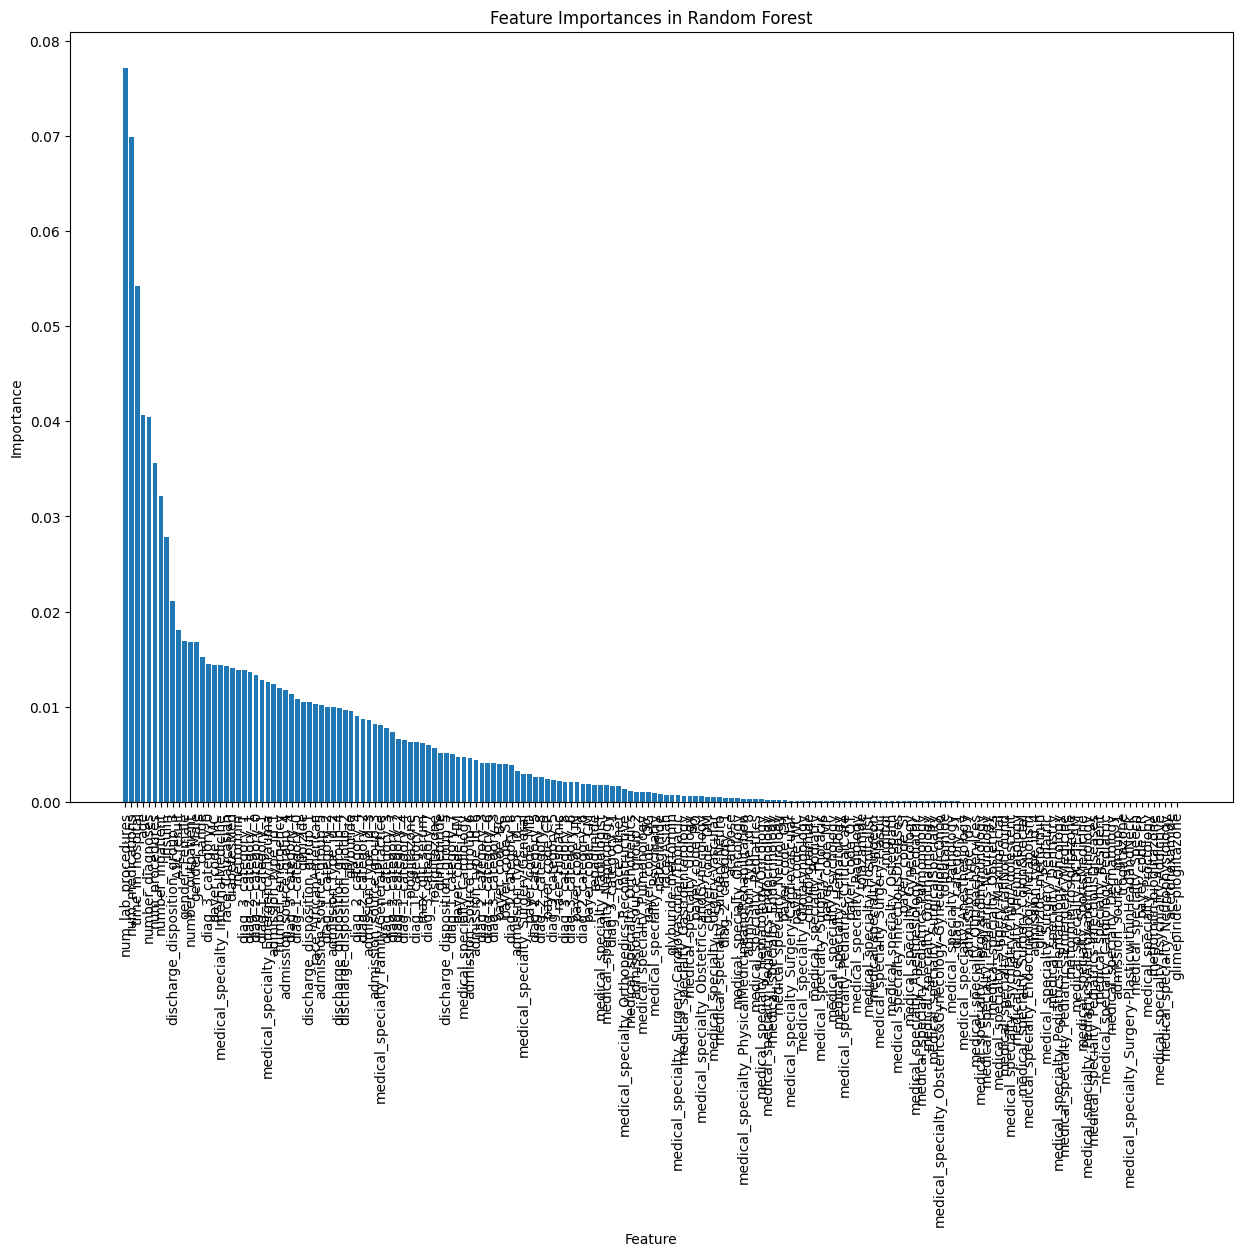

Feature Importances:
num_lab_procedures: 0.0771
num_medications: 0.0699
time_in_hospital: 0.0543
age: 0.0406
number_diagnoses: 0.0404
num_procedures: 0.0356
number_inpatient: 0.0322
insulin: 0.0278
discharge_disposition_group_3: 0.0211
A1Cresult: 0.0180
gender_Female: 0.0169
number_outpatient: 0.0168
gender_Male: 0.0168
change: 0.0152
diag_3_category_0: 0.0145
payer_code_MC: 0.0144
medical_specialty_InternalMedicine: 0.0143
race_Caucasian: 0.0142
diabetesMed: 0.0141
metformin: 0.0138
diag_3_category_1: 0.0138
diag_2_category_1: 0.0137
diag_2_category_0: 0.0133
diag_1_category_1: 0.0128
medical_specialty_Emergency/Trauma: 0.0126
admission_type_id_1: 0.0124
number_emergency: 0.0119
admission_source_group_4: 0.0118
diag_3_category_4: 0.0113
diag_1_category_0: 0.0108
glipizide: 0.0105
discharge_disposition_group_1: 0.0105
race_AfricanAmerican: 0.0102
admission_source_group_5: 0.0101
diag_1_category_2: 0.0100
admission_type_id_2: 0.0100
discharge_disposition_group_4: 0.0099
discharge_dispos

In [775]:
# Get feature importances from the model
feature_importances = rf_clf.feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]
sorted_features = X_encoded.columns[sorted_indices]

# Plotting all feature importances
plt.figure(figsize=(15, 10))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90)
plt.title('Feature Importances in Random Forest')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

print("Feature Importances:")
for idx in sorted_indices:
    print(f"{X_encoded.columns[idx]}: {feature_importances[idx]:.4f}")

In this computation, we will focus on MLP model training (should have better result)

### MLP Model

In [776]:
mlp = MLPClassifier(learning_rate='constant', learning_rate_init=0.0001, max_iter=50000, activation='relu', solver='adam', hidden_layer_sizes=(35, 70, 3), random_state=1)


### Training of the MLP Begins

In [777]:
# Fit the classifier with one-hot encoded labels
mlp.fit(X_train_scaled, y_train_smote)

MLPClassifier(hidden_layer_sizes=(35, 70, 3), learning_rate_init=0.0001,
              max_iter=50000, random_state=1)

In [778]:
# Predict probabilities using one-hot encoded labels
y_train_preds_mlp = mlp.predict_proba(X_train_scaled)
y_test_preds_mlp = mlp.predict_proba(X_test_scaled)

In [779]:
y_train_preds_mlp

array([[2.68039991e-01, 1.49348442e-01, 5.82611567e-01],
       [5.73198551e-01, 9.61228848e-02, 3.30678565e-01],
       [1.47105844e-01, 1.72438046e-01, 6.80456111e-01],
       ...,
       [2.83545035e-09, 8.44227991e-01, 1.55772006e-01],
       [1.25776435e-08, 8.05947185e-01, 1.94052802e-01],
       [7.16548241e-05, 4.56899203e-01, 5.43029142e-01]])

In [780]:
y_test_preds_mlp

array([[0.59465463, 0.08410898, 0.32123639],
       [0.63359763, 0.07617961, 0.29022276],
       [0.92600945, 0.02135693, 0.05263363],
       ...,
       [0.81075015, 0.03978056, 0.14946929],
       [0.77654873, 0.04685142, 0.17659984],
       [0.45576829, 0.11216421, 0.43206749]])

In [781]:
# Convert predicted probabilities to class labels
y_train_preds_labels = np.argmax(y_train_preds_mlp, axis=1)
y_test_preds_labels = np.argmax(y_test_preds_mlp, axis=1)


In [782]:
y_train_preds_labels

array([2, 0, 2, ..., 1, 1, 2], dtype=int64)

In [783]:
y_train_smote

array([0, 0, 2, ..., 2, 2, 2], dtype=int64)

In [784]:
y_test_preds_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [785]:
y_test

array([0, 0, 1, ..., 2, 2, 1], dtype=int64)

### Specificity Report

In [797]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report

# Calculate prevalence for each class in a multi-class setting with class labels.
def calc_prevalence(y_true, class_labels):
    unique, counts = np.unique(y_true, return_counts=True)
    total = len(y_true)
    prevalence = {class_labels[k]: v / total for k, v in zip(unique, counts)}
    return prevalence

# Calculate specificity for each class in a multi-class setting.
def calc_specificity(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_labels)))
    specificity = {}
    for i, label in enumerate(class_labels):
        true_negatives = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        actual_negatives = cm.sum() - cm[i, :].sum()
        specificity[label] = true_negatives / actual_negatives if actual_negatives else 0
    return specificity

def print_label_and_value(data):
    for label, value in data.items():
        print(f"{label}: {value}")

def print_confusion_matrix(y_true, y_pred, class_labels=["NO readmitted", "<30 days readmitted", ">30 days readmitted"], str_title=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(str_title + " Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")
    
    # Overall metrics
    print("Overall Metrics:\n", classification_report(y_true, y_pred, target_names=class_labels))
    
    # Class-specific metrics (specificity and prevalence)
    specificity = calc_specificity(y_true, y_pred, class_labels)
    prevalence = calc_prevalence(y_true, class_labels)
    print("Specificity by Class:")
    print_label_and_value(specificity)
    print("Prevalence by Class:")
    print_label_and_value(prevalence)
    
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

Training:
Overall Metrics:
                      precision    recall  f1-score   support

      NO readmitted       0.69      0.84      0.76     34553
<30 days readmitted       0.75      0.75      0.75     34553
>30 days readmitted       0.59      0.46      0.52     34553

           accuracy                           0.68    103659
          macro avg       0.68      0.68      0.68    103659
       weighted avg       0.68      0.68      0.68    103659

Specificity by Class:
NO readmitted: 0.8145747113130553
<30 days readmitted: 0.8732671548056609
>30 days readmitted: 0.838523427777617
Prevalence by Class:
NO readmitted: 0.3333333333333333
<30 days readmitted: 0.3333333333333333
>30 days readmitted: 0.3333333333333333


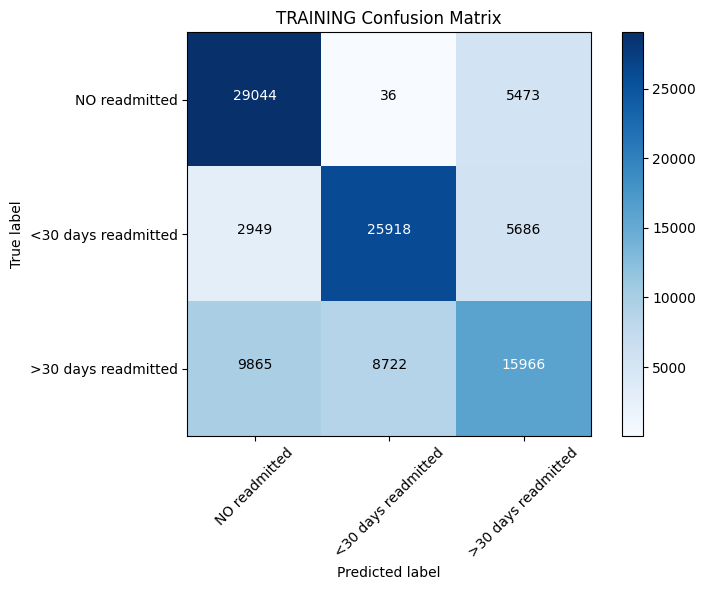




Test:
Overall Metrics:
                      precision    recall  f1-score   support

      NO readmitted       0.62      0.74      0.67     14808
<30 days readmitted       0.24      0.03      0.06      3052
>30 days readmitted       0.45      0.43      0.44      9370

           accuracy                           0.56     27230
          macro avg       0.43      0.40      0.39     27230
       weighted avg       0.52      0.56      0.52     27230

Specificity by Class:
NO readmitted: 0.45145709225567543
<30 days readmitted: 0.9867234676151874
>30 days readmitted: 0.7220604703247481
Prevalence by Class:
NO readmitted: 0.5438119720896071
<30 days readmitted: 0.11208226221079691
>30 days readmitted: 0.34410576569959606


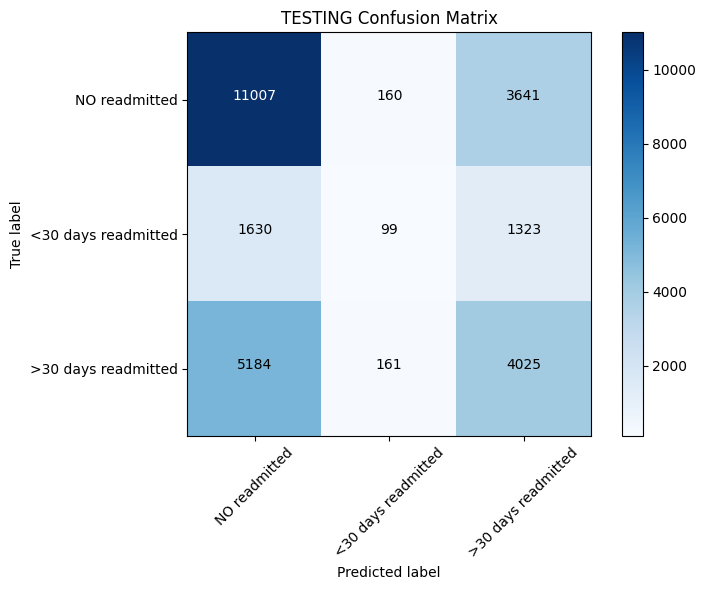

In [798]:
print('Training:')
print_confusion_matrix(y_train_smote, y_train_preds_labels, str_title="TRAINING")

print('\n\n\nTest:')
print_confusion_matrix(y_test, y_test_preds_labels, str_title="TESTING")

Now we can play the hyper parameter of the mlp

"Once you have your model trained, predict the readmission of the patients in the C2T1_Test.csv file. Create a labeled C2T1_Test_Labled.csv file using your predictive model to predict the readmission values for the patient records in the C2T1_Test.csv file. Your C2T1_Test_Lableled.csv file should look like this: encounter_id,patient_nbr, readmitted 168899772,88565423, No 168903044,61086362, <30 168903046,61086362, >30"

In [799]:
test_add_label = pd.read_csv(testing_file)

In [800]:
test_add_label

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,168899775,88565423,Caucasian,Male,[60-70),?,3,1,1,2,...,No,No,No,No,No,No,No,Ch,Yes,NaN
1,168901359,88590695,Caucasian,Male,[60-70),?,5,1,1,1,...,No,No,No,No,No,No,No,No,Yes,NaN
2,168903045,61086362,AfricanAmerican,Female,[70-80),?,1,1,1,2,...,No,No,No,No,No,No,No,No,No,NaN
3,168903927,85993970,Caucasian,Male,[70-80),?,1,1,7,2,...,No,Steady,No,No,No,No,No,No,Yes,NaN
4,168904515,45884291,Caucasian,Male,[50-60),?,2,1,2,5,...,No,Down,No,No,No,No,No,Ch,Yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,206091009,93935111,Caucasian,Female,[60-70),?,3,1,1,2,...,No,Steady,No,No,No,No,No,No,Yes,NaN
10996,206098845,112735382,Caucasian,Male,[70-80),?,3,1,1,1,...,No,No,No,No,No,No,No,No,No,NaN
10997,206100591,89262995,Caucasian,Male,[70-80),?,3,1,1,5,...,No,Down,No,No,No,No,No,Ch,Yes,NaN
10998,206117205,106914191,Caucasian,Male,[80-90),?,1,6,7,8,...,No,Up,No,No,No,No,No,Ch,Yes,NaN


Do the same data cleaning

In [801]:
# Change ? to NA
test_add_label.replace('?',pd.NA, inplace=True)
# Drop 'weight'
test_add_label.drop(['weight'], axis=1, inplace=True)
# Drop 'examide' and 'citoglipton'
test_add_label.drop(['examide', 'citoglipton'], axis=1, inplace=True)
# Fill NaN values in 'race' with Caucasian
test_add_label['race'] = test_add_label['race'].fillna('Caucasian')
# Replace 'Unknown/Invalid' with 'Female'
test_add_label['gender'] = test_add_label['gender'].replace('Unknown/Invalid', 'Female').infer_objects(copy=False)
# Group age
test_add_label['age'] = test_add_label['age'].apply(map_new_age_group)
# Group discharge disposition
